In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import open_clip
from torchvision import datasets, transforms
import torch
from PIL import Image
import open_clip
from tqdm import tqdm
from torch.utils.data import DataLoader
import numpy as np
from sklearn import calibration
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch.nn as nn
import torch.optim as optim
from sklearn.tree import DecisionTreeRegressor as DT
from sklearn.isotonic import IsotonicRegression as IR
from scipy.stats import norm
from tqdm import tqdm
import pandas as pd

/home/ubuntu/anaconda3/envs/content_understanding/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from util import get_preds, calc_bins, get_metrics, T_scaling, find_temp_scale, get_test_set, get_openai_prompts, get_val_set, find_temp_scale_with_q, get_text_probs, sample_quantile, run_modified_uts

In [4]:
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
batch_size = 128

In [5]:
model_name = 'ViT-B-32' # 'ViT-B-32-quickgelu' 
model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained='laion2b_s34b_b79k', device=device)
tokenizer = open_clip.get_tokenizer(model_name)

In [6]:
dataset_name = 'CIFAR100'
num_classes = 100
cifar_test = datasets.CIFAR100('/home/ubuntu/data/', train = False, transform = preprocess, download=True)
cifar_train = datasets.CIFAR100('/home/ubuntu/data/', train = True, transform = preprocess, download=True)
classes, templates = get_openai_prompts(dataset_name)
cifar_test.classes = classes
cifar_train.classes = classes

Files already downloaded and verified
Files already downloaded and verified


In [33]:
def get_subset(test_dset, train_dset, n_classes, size_train, size_test):
    np.random.seed(0)
    classes_to_keep = np.random.choice(range(100), n_classes, replace=False)
    def find_subset(dset, size):
        subset_in_classes = []
        for c in classes_to_keep:
            appending = np.where(np.array(dset.targets) == c)[0][:size // n_classes]
            subset_in_classes.extend(appending.tolist())
        subset = torch.utils.data.Subset(dset, subset_in_classes)
        subset.classes = classes
        return subset
    return find_subset(test_dset,size_test ), find_subset(train_dset, size_train)

In [102]:
test_datasets = {}
val_datasets = {}
for n in [10, 20, 25, 40, 50, 75, 100]:
    test_datasets[n], val_datasets[n] = get_subset(cifar_test, cifar_train, n, 5000, 1000)

In [122]:
t = templates[0]
normal_ece = {}
scaled_eces = {}
scaled_temps = {}
for n in tqdm(test_datasets):
    predictions, actual, probs = get_preds(model, tokenizer, test_datasets[n], text_template=t)
    ece, mce, acc = get_metrics(predictions, actual, probs)
    normal_ece[n] = ece

    val_text_probs = get_text_probs(model, tokenizer, val_datasets[n], text_template=t)
    temps_learned, eces_learned = sample_quantile(0.95, 0.9999, 0.005, val_text_probs , device, model, tokenizer, test_datasets[n], t)
    scaled_eces[n] = eces_learned 
    scaled_temps[n] = temps_learned

100%|██████████| 7/7 [16:25<00:00, 140.85s/it]


In [158]:
def func(n_classes):
    return 1 - (1.25 * np.log10(n_classes)) / n_classes

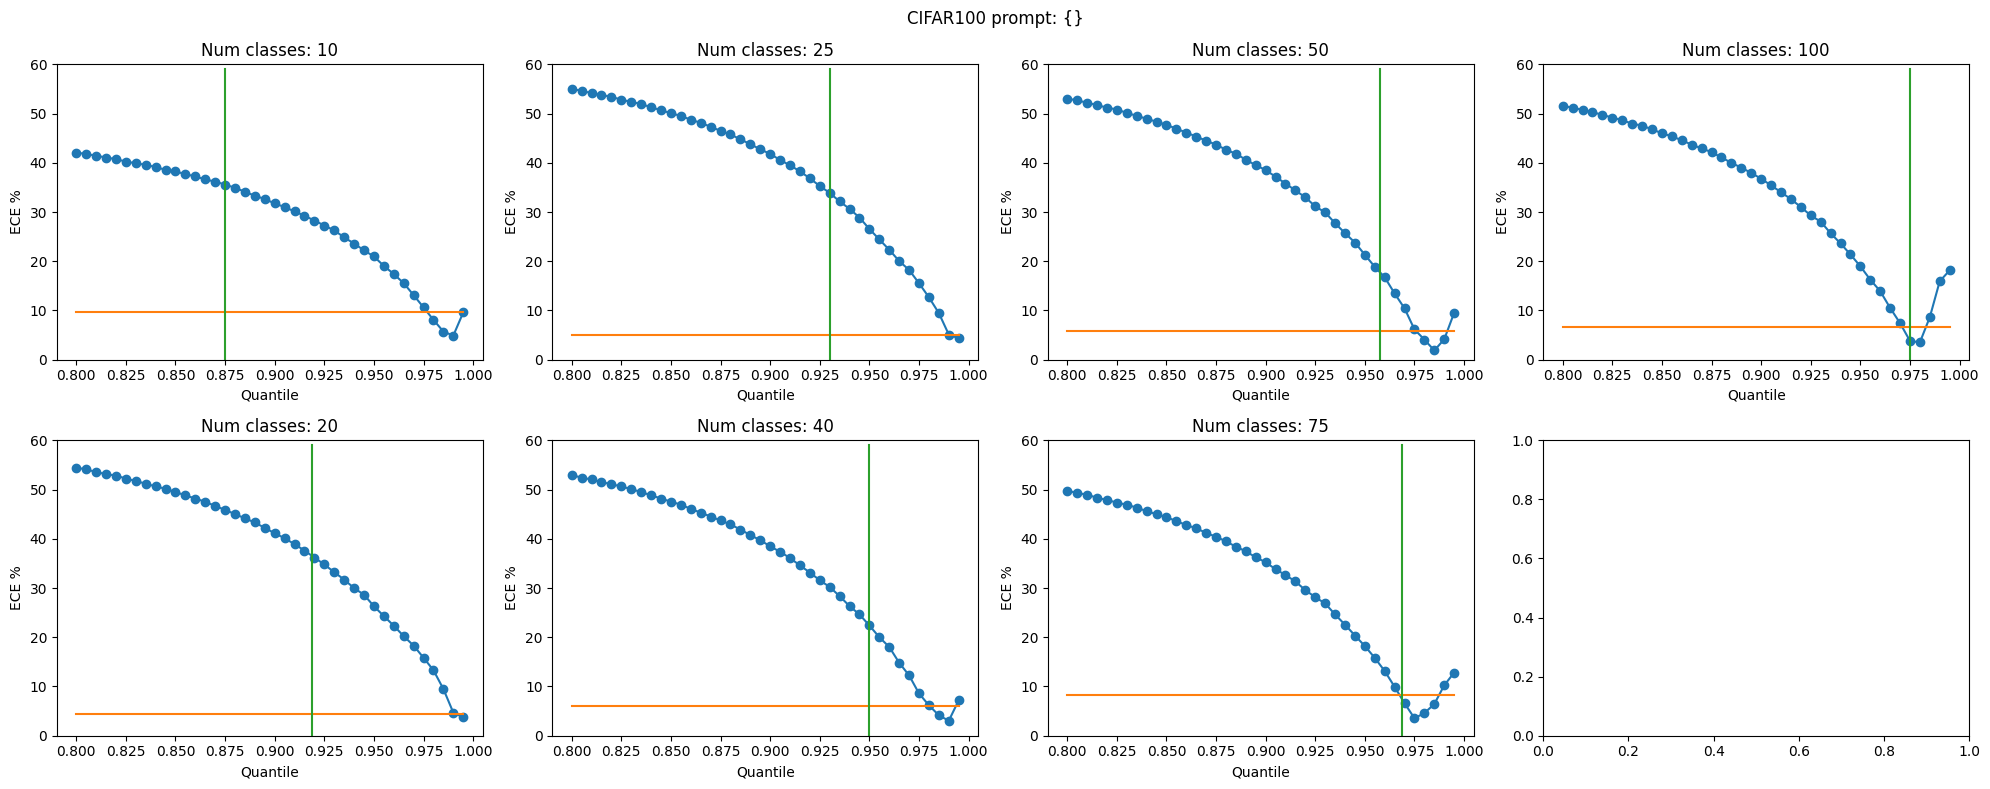

In [162]:
fig, axarr = plt.subplots(2,4, figsize=(20,8))
xaxis = np.arange(0.8, 0.9999, 0.005)
for i,k in enumerate(sorted(scaled_eces)):
    axarr[i % 2, i // 2 ].plot(xaxis, np.array(scaled_eces[k]) * 100, marker='o')
    axarr[i % 2, i // 2].plot(xaxis, np.array([normal_ece[k]]*len(xaxis)) * 100, '-')
    axarr[i % 2, i // 2].plot( [func(k)] * 60, np.arange(0,60), '-')
    axarr[i % 2, i // 2].set_title(f"Num classes: {k}")
    axarr[i % 2, i // 2].set_xlabel('Quantile')
    axarr[i % 2, i // 2].set_ylabel('ECE %')
    axarr[i % 2, i // 2].set_ylim(0, 60)
plt.suptitle(f"CIFAR100 prompt: {t}")
plt.tight_layout()

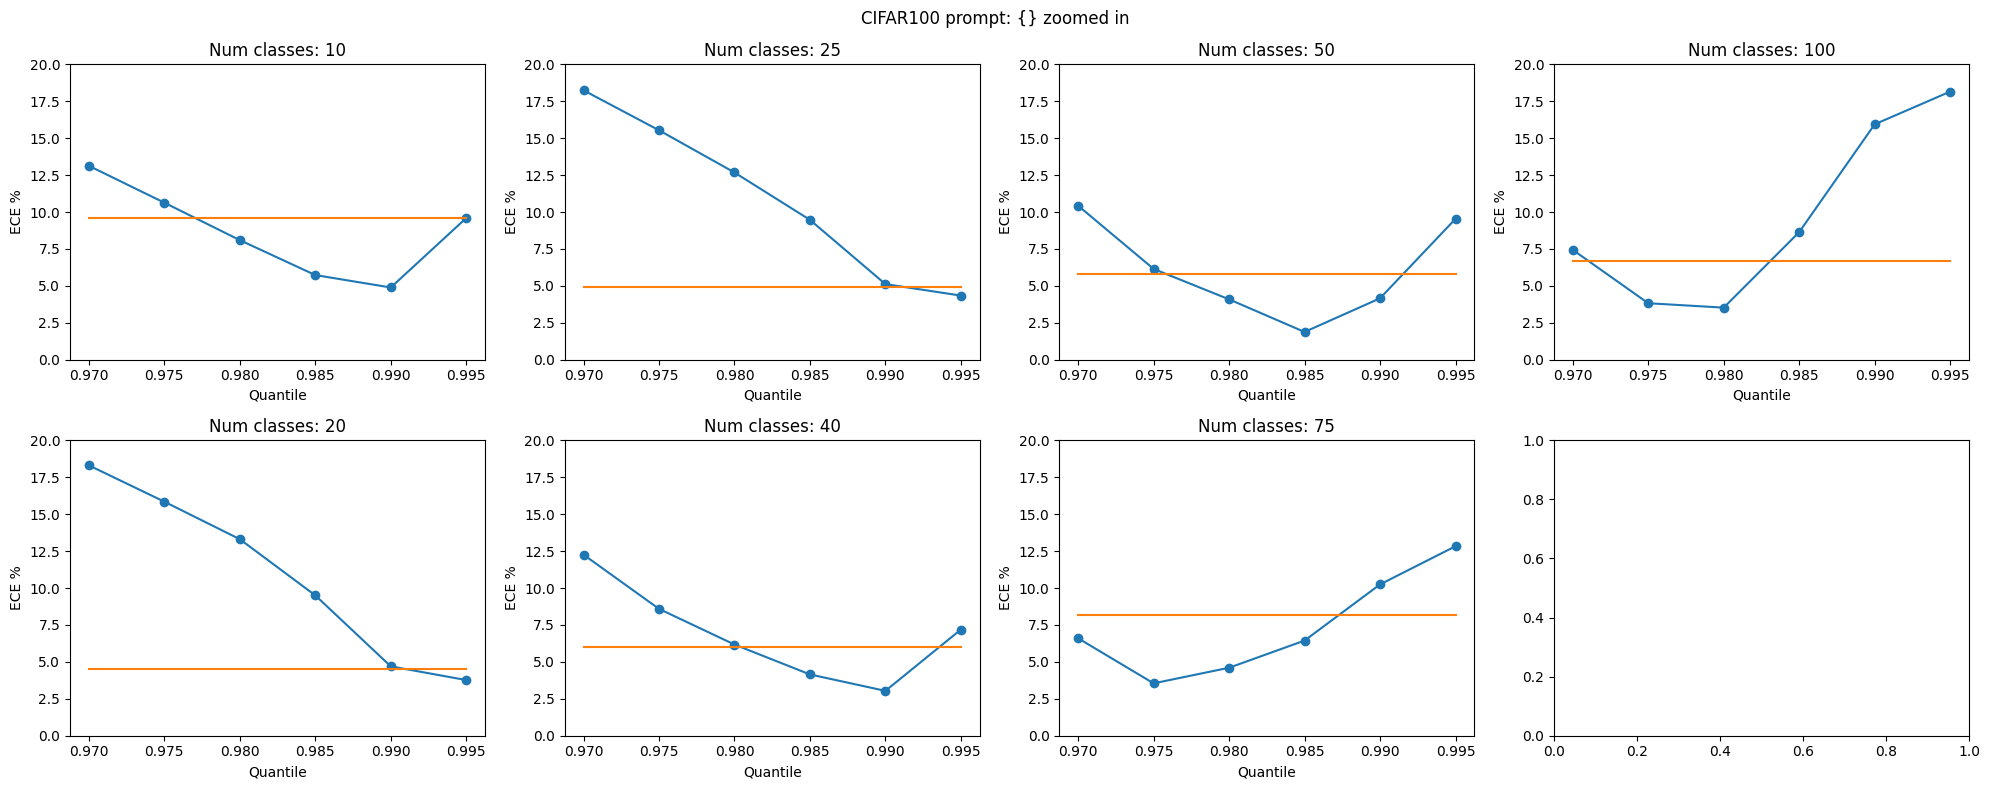

In [157]:
fig, axarr = plt.subplots(2,4, figsize=(20,8))
xaxis = np.arange(0.8, 0.9999, 0.005)
for i,k in enumerate(sorted(scaled_eces)):
    axarr[i % 2, i // 2 ].plot(xaxis[-6:], np.array(scaled_eces[k])[-6:] * 100, marker='o')
    axarr[i % 2, i // 2].plot(xaxis[-6:], np.array([normal_ece[k]]*len(xaxis))[-6:] * 100, '-')
    axarr[i % 2, i // 2].set_title(f"Num classes: {k}")
    axarr[i % 2, i // 2].set_xlabel('Quantile')
    axarr[i % 2, i // 2].set_ylabel('ECE %')
    axarr[i % 2, i // 2].set_ylim(0, 20)
plt.suptitle(f"CIFAR100 prompt: {t} zoomed in")
plt.tight_layout()

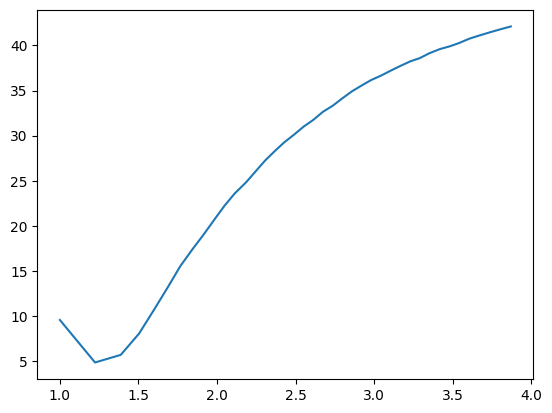

In [119]:
plt.plot(temps_learned, np.array(eces_learned) * 100.0)

Quantile Sweep

In [43]:
models_to_consider = [
    ('ViT-B-16', 'openai'),
    #('ViT-B-32', 'laion400m_e31'),
    ('ViT-B-16', 'laion400m_e31'),
    #('ViT-B-32', 'laion2b_e16'),
    ('ViT-B-16', 'laion2b_s34b_b88k'),
   #  ('ViT-B-16', 'openai'),
 #('ViT-B-16', 'laion400m_e31'),
 #('ViT-B-16', 'laion400m_e32'),
 #('ViT-B-16', 'laion2b_s34b_b88k'),
  ('ViT-L-14', 'openai'),
 #('ViT-L-14', 'laion400m_e31'),
 ('ViT-L-14', 'laion400m_e31'),
 ('ViT-L-14', 'laion2b_s32b_b82k'),
 #   ('ViT-H-14' , 'laion2b_s32b_b79k'),
 #   ('convnext_base', 'laion400m_s13b_b51k'),
 #('convnext_base_w', 'laion2b_s13b_b82k'),
 # ('convnext_base_w', 'laion_aesthetic_s13b_b82k'),
 ('RN50', 'openai'),
 ('RN50', 'yfcc15m'),
 ('RN50', 'cc12m')
    #('ViT-bigG-14' , 'laion2b_s39b_b160k'),
    #('ViT-B-32', 'openai')
]

In [30]:
datasets_consider = [
    ['CIFAR10', 10],
    #['CIFAR100', 100]    
]

Text(0.5, 1.0, 'Difference in ECE % from Normal across Different models, pretraining datasets, and prompts')

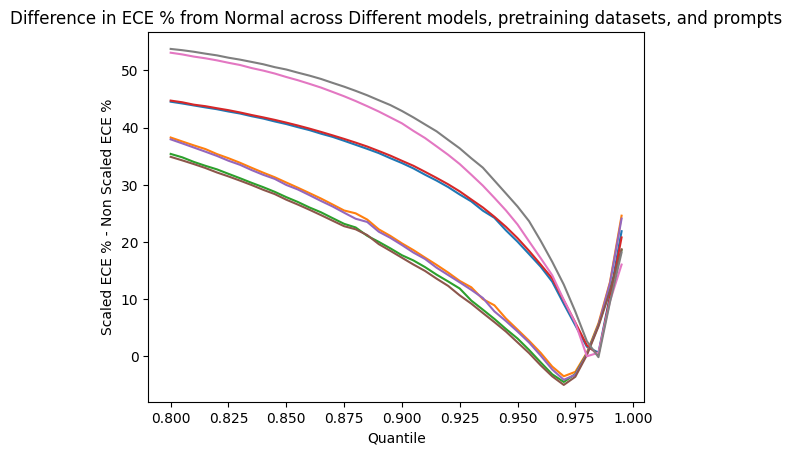

In [85]:
xaxis = np.arange(0.85,0.9999, 0.005)
for k in model_eces_scaled:
    for i in range(len(templates)):
        plt.plot(xaxis, np.array(model_eces_scaled[k][i] - model_eces[k][i]) * 100.0)
#for k in model_eces:
#    for i in range(len(templates)):
#        plt.plot(xaxis, [model_eces[k][i]] * len(xaxis), '-')
plt.xlabel('Quantile')
plt.ylabel('Scaled ECE % - Non Scaled ECE %')
plt.title('Difference in ECE % from Normal across Different models, pretraining datasets, and prompts')

In [51]:
model_eces_scaled['ViT-B-16;laion400m_e32'][0][-2]# - model_eces_sca['ViT-B-16;laion400m_e32'][0]

0.06027028471231462

In [72]:
model_name, pretrained_dset = 'ViT-B-16', 'laion400m_e32'
model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained=pretrained_dset, device=device)
tokenizer = open_clip.get_tokenizer(model_name)

cifar_test, _ = get_test_set(dataset_name, preprocess)
        
#cifar_test = datasets.CIFAR10('/home/ubuntu/data/', train = False, transform = preprocess, download=True)
classes, templates = get_openai_prompts(dataset_name)
val_dset = get_val_set(dataset_name, classes, preprocess)

#scaled_temp = find_temp_scale(model, tokenizer, val_dset, num_classes=num_classes, text_template=t, device=device)
#predictions, actual, probs_scaled = get_preds(model, tokenizer, cifar_test, text_template=t, temp_scaling=scaled_temp, device=device)
val_text_probs = get_text_probs(model, tokenizer, val_dset, text_template=t, device=device)
scaled_temp = find_temp_scale_with_q(0.875, val_text_probs, device)
predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_template=t, temp_scaling=scaled_temp, device=device)
get_metrics(predictions, actual, probs)

Files already downloaded and verified
Files already downloaded and verified


(0.004610295958816986, 0.1799446977674961, 0.9194)

In [73]:
scaled_temp = find_temp_scale_with_q(0.88, val_text_probs, device)
predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_template=t, temp_scaling=scaled_temp, device=device)
get_metrics(predictions, actual, probs)

(0.010622146081924418, 0.18297716975212097, 0.9192)

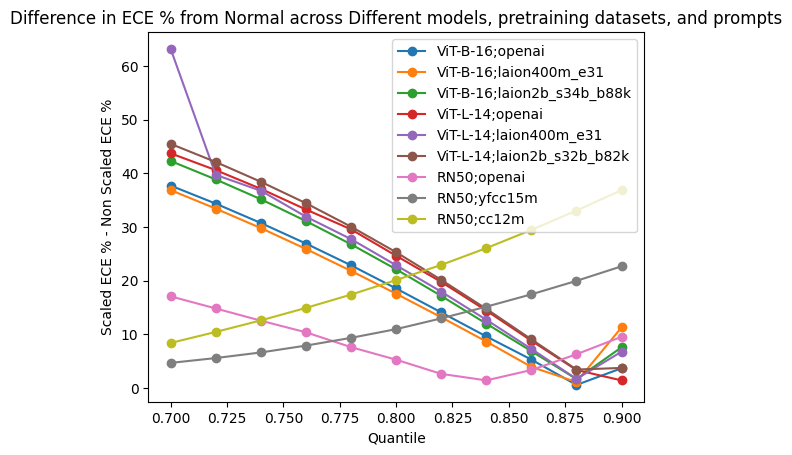

In [84]:
xaxis = np.arange(0.7, 0.90, 0.02)#[30:]
for k in model_eces_scaled:
    for i in [0]:#range(1,len(templates)):
        if True:#model_eces_scaled[k][i][-4] - model_eces[k][i] >= 0:
            #plt.plot(xaxis, np.array(model_eces_scaled[k][i] - model_eces[k][i]) * 100.0)
            plt.plot(xaxis, np.array(model_eces_scaled[k][i]) * 100.0, label=f"{k}", marker='o')
            #print(model_eces[k][i])
#for k in model_eces:
#    for i in range(len(templates)):
#        plt.plot(xaxis, [model_eces[k][i]] * len(xaxis), '-')
plt.xlabel('Quantile')
plt.ylabel('Scaled ECE % - Non Scaled ECE %')
plt.title('Difference in ECE % from Normal across Different models, pretraining datasets, and prompts')
plt.legend()

In [105]:
for model_name, pretrained_dset in tqdm(models_to_consider):
    if model_name + ';' + pretrained_dset in model_eces_scaled:
        model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained=pretrained_dset, device=device)
        tokenizer = open_clip.get_tokenizer(model_name)

        cifar_test = datasets.CIFAR100('/home/ubuntu/data/', train = False, transform = preprocess, download=True)
        classes, templates = get_openai_prompts(dataset_name)
        cifar_test.classes = classes
        val_dset = get_val_set(dataset_name, classes, preprocess)

        scaled_eces = []
        scaled_temps = []
        normal_eces = []
        for t in templates:

            predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_template=t, device=device)
            ece, _, _ = get_metrics(predictions, actual, probs)
            normal_eces.append(ece)
        model_eces[model_name + ';' + pretrained_dset] = normal_eces


  0%|          | 0/21 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified


  5%|▍         | 1/21 [02:29<49:50, 149.54s/it]

Files already downloaded and verified
Files already downloaded and verified


 10%|▉         | 2/21 [04:53<46:19, 146.27s/it]

Files already downloaded and verified
Files already downloaded and verified


 14%|█▍        | 3/21 [07:15<43:13, 144.11s/it]

Files already downloaded and verified
Files already downloaded and verified


 19%|█▉        | 4/21 [09:36<40:34, 143.19s/it]

Files already downloaded and verified
Files already downloaded and verified


 24%|██▍       | 5/21 [11:56<37:49, 141.84s/it]

Files already downloaded and verified
Files already downloaded and verified


 29%|██▊       | 6/21 [17:28<51:38, 206.58s/it]

Files already downloaded and verified
Files already downloaded and verified


 33%|███▎      | 7/21 [22:43<56:28, 242.03s/it]

Files already downloaded and verified
Files already downloaded and verified


 38%|███▊      | 8/21 [28:02<57:46, 266.68s/it]

Files already downloaded and verified
Files already downloaded and verified


 43%|████▎     | 9/21 [33:17<56:19, 281.59s/it]

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 21/21 [51:04<00:00, 145.93s/it]  


In [15]:
import json
with open(f'numbers/quantile_sweep_{dataset_name}_acrossprompt.json', 'w') as f:
        json.dump({
            'model_eces' : model_eces,
            'model_eces_scaled' : model_eces_scaled,
            'model_temps' : model_temps,
            'quantiles' : np.arange(0.85, 0.90, 0.005).tolist()
        },f)

In [82]:
dataset_eces = {}
dataset_temps = {}
dataset_eces_scaled = {}
for dataset_name, num_classes in datasets_consider:
    #model_eces = {}
    #model_eces_scaled = {}
    #model_temps = {}
    for model_name, pretrained_dset in tqdm(models_to_consider):
        if model_name + ';' + pretrained_dset in model_eces:
            continue
        
        model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained=pretrained_dset, device=device)
        tokenizer = open_clip.get_tokenizer(model_name)

        cifar_test, _ = get_test_set(dataset_name, preprocess)
        
        #cifar_test = datasets.CIFAR10('/home/ubuntu/data/', train = False, transform = preprocess, download=True)
        classes, templates = get_openai_prompts(dataset_name)
        val_dset = get_val_set(dataset_name, classes, preprocess)

        #cifar_test, val_dset = get_subset(cifar_test, val_dset, num_classes, 1000, 1000)

        scaled_eces = []
        scaled_temps = []
        normal_eces = []
        for t in [templates[1]]:#tqdm(templates[1:5]):

            predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_template=t, device=device)
            ece, _, _ = get_metrics(predictions, actual, probs)
            normal_eces.append(ece)

            val_text_probs = get_text_probs(model, tokenizer, val_dset, text_template=t, device=device)
            temps_learned, eces_learned = sample_quantile(0.7, 0.90, 0.02, val_text_probs , device, model, tokenizer, cifar_test, t)
            scaled_eces.append(eces_learned) 
            scaled_temps.append(temps_learned)
        model_temps[model_name + ';' + pretrained_dset] = scaled_temps
        model_eces_scaled[model_name + ';' + pretrained_dset] = scaled_eces
        model_eces[model_name + ';' + pretrained_dset] = normal_eces
    dataset_eces[dataset_name] = model_eces
    dataset_eces_scaled[dataset_name] = model_eces_scaled
    dataset_temps[dataset_name] = model_temps

  0%|          | 0/9 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified


 22%|██▏       | 2/9 [04:13<14:48, 126.87s/it]

Files already downloaded and verified
Files already downloaded and verified


 33%|███▎      | 3/9 [08:11<17:19, 173.20s/it]

Files already downloaded and verified
Files already downloaded and verified


 44%|████▍     | 4/9 [20:41<32:20, 388.17s/it]

Files already downloaded and verified
Files already downloaded and verified


 56%|█████▌    | 5/9 [32:44<33:38, 504.67s/it]

Files already downloaded and verified
Files already downloaded and verified


 67%|██████▋   | 6/9 [44:39<28:43, 574.43s/it]

Files already downloaded and verified
Files already downloaded and verified


 78%|███████▊  | 7/9 [47:11<14:37, 438.62s/it]

Files already downloaded and verified
Files already downloaded and verified


 89%|████████▉ | 8/9 [49:45<05:49, 349.07s/it]

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 9/9 [52:20<00:00, 348.89s/it]


In [8]:
dataset_name='CIFAR100'
num_classes=100
cifar_test = datasets.CIFAR100('/home/ubuntu/data/', train = False, transform = preprocess, download=True)
classes, templates = get_openai_prompts(dataset_name)
cifar_test.classes = classes
val_dset = get_val_set(dataset_name, classes, preprocess)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
t = templates[1]
x_axis = np.arange(0.970, 0.999, 0.0005)

predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_template=t, device=device)
ece, mce, acc = get_metrics(predictions, actual, probs)


val_text_probs = get_text_probs(model, tokenizer, val_dset, text_template=t, device=device)
temps_learned, eces_learned = sample_quantile(0.970, 0.999, 0.0005, val_text_probs , device, model, tokenizer, cifar_test, t)

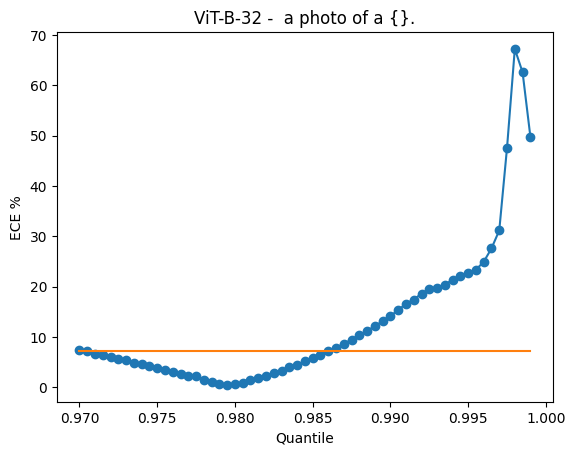

In [17]:
plt.plot(x_axis,np.array(eces_learned)*100, marker='o')
plt.title(f"{model_name} -  {t}")
plt.ylabel('ECE %')
plt.xlabel('Quantile')
plt.plot(x_axis, np.array([ece]*len(x_axis)) * 100, '-')

In [19]:
def find_temp_scale_mod(model, tokenizer, val_dset, num_classes=100, text_template='{}', batch_size=128,
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')):

    text_probs = get_text_probs(
        model=model,
        tokenizer=tokenizer,
        dset=val_dset,
        text_template=text_template,
        batch_size=batch_size,
        device=device
    )
    def func(n_classes):
        return 1 - (1 * np.log10(n_classes)) / n_classes
    q = func(num_classes)
    return find_temp_scale_with_q(q, text_probs, device)

In [31]:
model_name = 'ViT-B-32'
pretrained_dset = 'openai'#'laion400m_e31'#'laion2b_s34b_b79k'
model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained=pretrained_dset, device=device)
tokenizer = open_clip.get_tokenizer(model_name)

dataset_name = 'CIFAR100'
num_classes = 100
cifar_test = datasets.CIFAR100('/home/ubuntu/data/', train = False, transform = preprocess, download=True)
classes, templates = get_openai_prompts(dataset_name)
cifar_test.classes = classes
val_dset = get_val_set(dataset_name, classes, preprocess)
# No scaling
eces = []
mces = []
accs = []
for t in tqdm(templates):
    predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_template=t, device=device)
    ece, mce, acc = get_metrics(predictions, actual, probs)
    eces.append(ece)
    accs.append(acc)
    mces.append(mce)

# With scaling
eces_scaled = []
mces_scaled = []
accs_scaled = []
temps = []
for t in tqdm(templates):
    scaled_temp = find_temp_scale_mod(model, tokenizer, val_dset, num_classes=num_classes, text_template=t, device=device)
    predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_template=t, temp_scaling=scaled_temp, device=device)
    ece, mce, acc = get_metrics(predictions, actual, probs)
    eces_scaled.append(ece)
    accs_scaled.append(acc)
    mces_scaled.append(mce)
    temps.append(scaled_temp)

100%|███████████████████████████████████████| 354M/354M [00:05<00:00, 63.9MiB/s]


Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 19/19 [08:40<00:00, 27.39s/it]


Text(0.5, 1.17, 'Calibration of CLIP with Different Prompts - CIFAR100 ViT-B-32 openai')

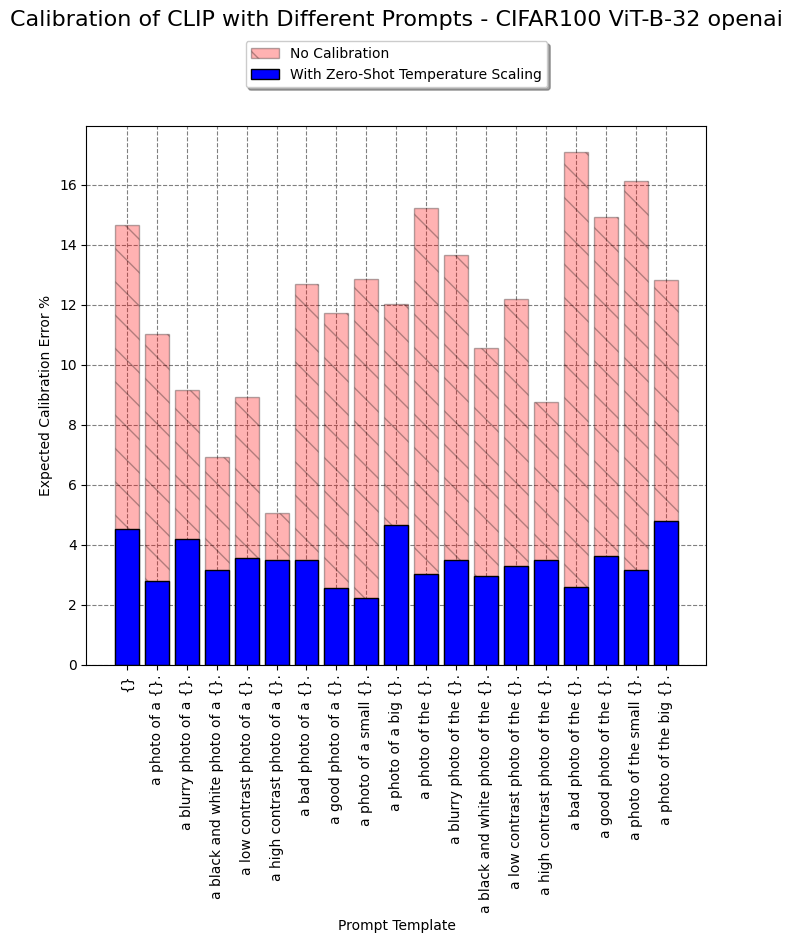

In [32]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()

# x/y limits
#ax.set_xlim(0, 1.05)
#ax.set_ylim(0, 1)

# x/y labels
plt.xlabel('Prompt Template')
plt.ylabel('Expected Calibration Error %')

# Create grid
ax.set_axisbelow(True) 
ax.grid(color='gray', linestyle='dashed')

# Error bars
plt.bar(templates, np.array(eces) * 100.0,  width=0.8, alpha=0.3, edgecolor='black', color='r', hatch='\\', label = 'No Calibration')
plt.xticks(rotation=90)


# Draw bars and identity line
plt.bar(templates, np.array(eces_scaled) * 100.0, width=0.8, alpha=1, edgecolor='black', color='b', label = 'With Zero-Shot Temperature Scaling')
#plt.plot([0,1],[0,1], '--', color='gray', linewidth=2)

# Equally spaced axes
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(bbox_to_anchor=(0.5, 1.17), fancybox=True, shadow=True, loc='upper center')
# ECE and MCE legend
#ECE_patch = mpatches.Patch(color='green', label='ECE = {:.2f}%'.format(ECE*100))
#MCE_patch = mpatches.Patch(color='red', label='MCE = {:.2f}%'.format(MCE*100))
#acc_patch = mpatches.Patch(color='orange', label='Overall Accuracy = {:.2f}%'.format(overall_acc*100))
#plt.legend(handles=[ECE_patch, MCE_patch, acc_patch])
plt.title(f'Calibration of CLIP with Different Prompts - {dataset_name} {model_name} {pretrained_dset}', y = 1.17, fontsize=16)

In [33]:
import json
with open(f'numbers/q1.0/{dataset_name}_{model_name}_{pretrained_dset}_acrossprompt.json', 'w') as f:
        json.dump({
            'eces_scaled' : eces_scaled,
            'mces_scaled' : mces_scaled,
            'accs_scaled' : accs_scaled,
            'eces' : eces,
            'mces' : mces,
            'accs' : accs,
            'temps' : temps
        },f)